In [1]:
from bs4 import BeautifulSoup
import requests
import time
import csv
from tqdm import tqdm
from transformers import pipeline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36"}

def scrape_all_pages(base_url, total_pages):
    all_articles = []  # Liste des articles collectés
    seen_articles = set()  # Ensemble pour éviter les doublons d'URL

    for page in range(1, total_pages + 1):
        url = f"{base_url}/{page}/" if page > 1 else base_url
        print(f"Scraping page: {url}")

        try:
            # Envoyer une requête HTTP pour récupérer la page
            response = requests.get(url, headers=headers, timeout=10)
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')

                # Trouver tous les articles via la classe "editoCardType10"
                articles = soup.find_all("section", class_="editoCardType10")

                for article in articles:
                    # Extraire le lien de l'article
                    link_element = article.find("a", class_="editoCardType10__link is-displayBlock")
                    article_url = link_element['href'] if link_element and link_element.has_attr('href') else ""

                    # Extraire le titre
                    title_element = article.find("h2", class_="editoCardType10__title")
                    title_text = title_element.get_text(strip=True) if title_element else ""

                    # Extraire le résumé
                    summary_element = article.find("p", class_="editoCardType10__text is-noMobile")
                    summary_text = summary_element.get_text(strip=True) if summary_element else "Résumé non disponible"

                    # Extraire la date de publication
                    date_element = article.find("time", class_="editoCardType10__date is-noMobile")
                    publication_date = date_element["datetime"] if date_element and date_element.has_attr("datetime") else "Date inconnue"

                    # Vérifier si l'article est déjà collecté
                    if article_url and article_url not in seen_articles:
                        # Ajouter l'article sous forme de dictionnaire
                        all_articles.append({
                            "title": title_text,
                            "summary": summary_text,
                            "url": f"https://www.lsa-conso.fr{article_url}",
                            "publication_date": publication_date
                        })
                        seen_articles.add(article_url)

            else:
                print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")

        except requests.RequestException as e:
            print(f"Erreur de requête pour {url}: {e}")

    return all_articles

# Utilisation
base_url = "https://www.lsa-conso.fr/marches/bio"
total_pages = 100
articles = scrape_all_pages(base_url, total_pages)



Scraping page: https://www.lsa-conso.fr/marches/bio


Scraping page: https://www.lsa-conso.fr/marches/bio/2/
Scraping page: https://www.lsa-conso.fr/marches/bio/3/
Scraping page: https://www.lsa-conso.fr/marches/bio/4/
Scraping page: https://www.lsa-conso.fr/marches/bio/5/
Scraping page: https://www.lsa-conso.fr/marches/bio/6/
Scraping page: https://www.lsa-conso.fr/marches/bio/7/
Scraping page: https://www.lsa-conso.fr/marches/bio/8/
Scraping page: https://www.lsa-conso.fr/marches/bio/9/
Scraping page: https://www.lsa-conso.fr/marches/bio/10/
Scraping page: https://www.lsa-conso.fr/marches/bio/11/
Scraping page: https://www.lsa-conso.fr/marches/bio/12/
Scraping page: https://www.lsa-conso.fr/marches/bio/13/
Scraping page: https://www.lsa-conso.fr/marches/bio/14/
Scraping page: https://www.lsa-conso.fr/marches/bio/15/
Scraping page: https://www.lsa-conso.fr/marches/bio/16/
Scraping page: https://www.lsa-conso.fr/marches/bio/17/
Scraping page: https://www.lsa-conso.fr/marches/bio/18/
Scraping page: https://www.lsa-conso.fr/marches/bio/19/


In [22]:
articles[:2]

[{'title': 'Bonneterre développe une filière de blé locale pour ses biscuits Petit Normand',
  'summary': 'La marque d’Ecotone consacrée aux réseaux bio noue un partenariat avec la coopérative Biocer, tout en étendant sa gamme de biscuits Petit Normand.',
  'url': 'https://www.lsa-conso.fr/bonneterre-developpe-une-filiere-de-ble-locale-pour-ses-biscuits-petit-normand,458386',
  'publication_date': '2024-12-05 08:12:00'},
 {'title': "Carrefour et la Coopération agricole s'engagent à soutenir l'agriculture biologique",
  'summary': "Carrefour et la Coopération agricole ont signé ce mercredi 27 novembre une Convention de partenariat en faveur du développement de l'agriculture biologique française. Cette convention vise à renforcer les liens entre Carrefour et les coopératives agricoles françaises, pour répondre aux enjeux...",
  'url': 'https://www.lsa-conso.fr/carrefour-et-la-cooperation-agricole-signent-une-convention-de-partenariat,458295',
  'publication_date': '2024-11-27 15:54:00'}]

In [23]:

# Charger explicitement le modèle de sentiment d'Hugging Face
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_bio_with_model(text):
    """
    Utilise un modèle open-source pour analyser le sentiment d'un texte concernant le bio.
    Le score sera entre 0 (négatif) et 1 (positif).
    """
    # Utiliser le modèle de sentiment pour prédire le sentiment
    result = sentiment_analyzer(text)

    # Le modèle retourne une liste avec un dictionnaire contenant les labels et scores
    sentiment = result[0]
    
    # Convertir le label en score : 'LABEL_1' est positif, 'LABEL_0' est négatif
    if sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return 1 - sentiment['score']  # Retourner un score entre 0 et 1 pour un sentiment négatif


Device set to use cpu


In [ ]:
def add_sentiment_score_to_articles(articles):
    """
    Applique l'analyse de sentiment sur chaque phrase ajoutée à l'article
    et ajoute la moyenne des scores de sentiment à chaque article.
    
    :param articles: Liste de dictionnaires contenant les articles enrichis avec des clés comme 'title', 'summary', 'url'.
    :return: Liste de dictionnaires enrichis avec le score de sentiment moyen.
    """
    for article in articles:
        # Extraire le résumé contenant "bio" (clé 'summary')
        summary = article.get("summary", "")

        if summary :  # Appliquer l'analyse de sentiment uniquement si le résumé contient "bio"
            # Appliquer l'analyse de sentiment au résumé
            sentiment_score = analyze_sentiment_bio_with_model(summary)

            # Ajouter le score de sentiment au dictionnaire
            article["sentiment_score"] = sentiment_score
        else:
            # Si le résumé ne contient pas "bio", définir le score comme 0
            article["sentiment_score"] = 0

    return articles

In [25]:
enriched_articles_with_sentiment = add_sentiment_score_to_articles(articles)

In [26]:
def save_to_csv_final(data, filename):
    """
    Enregistre la liste de dictionnaires au format CSV.
    
    :param data: Liste de dictionnaires contenant les données des articles.
    :param filename: Nom du fichier CSV de sortie.
    """
    # Définir les en-têtes en fonction des clés des dictionnaires
    headers = [
        "Title", 
        "Summary", 
        "URL", 
        "Publication_Date", 
        "Sentiment_Score"
    ]
    
    # Écriture dans le fichier CSV
    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        
        # Écrire les en-têtes
        writer.writeheader()
        
        # Écrire les données
        for article in data:
            # Extraire les données à partir du dictionnaire
            row = {
                "Title": article.get("title", ""),
                "Summary": article.get("summary", ""),
                "URL": article.get("url", ""),
                "Publication_Date": article.get("publication_date", ""),
                "Sentiment_Score": article.get("sentiment_score", 0)
            }
            writer.writerow(row)

    print(f"Les données ont été enregistrées dans le fichier '{filename}'.")


# Enregistrement des articles enrichis avec score de sentiment dans un fichier CSV
save_to_csv_final(enriched_articles_with_sentiment, "articles_LSA_sentiment.csv")

Les données ont été enregistrées dans le fichier 'articles_LSA_sentiment.csv'.


In [27]:
enriched_articles_with_sentiment[:2]

[{'title': 'Bonneterre développe une filière de blé locale pour ses biscuits Petit Normand',
  'summary': 'La marque d’Ecotone consacrée aux réseaux bio noue un partenariat avec la coopérative Biocer, tout en étendant sa gamme de biscuits Petit Normand.',
  'url': 'https://www.lsa-conso.fr/bonneterre-developpe-une-filiere-de-ble-locale-pour-ses-biscuits-petit-normand,458386',
  'publication_date': '2024-12-05 08:12:00',
  'sentiment_score': 0.7480549216270447},
 {'title': "Carrefour et la Coopération agricole s'engagent à soutenir l'agriculture biologique",
  'summary': "Carrefour et la Coopération agricole ont signé ce mercredi 27 novembre une Convention de partenariat en faveur du développement de l'agriculture biologique française. Cette convention vise à renforcer les liens entre Carrefour et les coopératives agricoles françaises, pour répondre aux enjeux...",
  'url': 'https://www.lsa-conso.fr/carrefour-et-la-cooperation-agricole-signent-une-convention-de-partenariat,458295',
  'p

In [28]:
def plot_months_with_color_based_on_score(data):
    """
    Génère un graphique montrant le nombre d'articles par mois, avec une couleur différente pour chaque mois
    en fonction du score moyen des articles de ce mois. Le score est extrait de la clé 'sentiment_score'.
    
    :param data: Liste de dictionnaires où la date de publication se trouve sous la clé 'publication_date'
                 et le score sous la clé 'sentiment_score'.
    """
    # Initialisation de dictionnaires pour compter les articles et calculer la somme des scores par mois
    articles_per_month = {}
    scores_per_month = {}

    # Boucle pour extraire les données pertinentes
    for entry in data:
        try:
            date_str = entry.get('publication_date')  # Récupérer la date
            score = entry.get('sentiment_score', 0)  # Récupérer le score (défaut : 0)

            # Vérifier que les deux champs existent
            if not date_str or not isinstance(score, (int, float)):
                continue

            # Conversion de la date au format 'YYYY-MM-DD HH:MM:SS'
            date_obj = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            
            # Formater la date pour obtenir le mois et l'année (format 'YYYY-MM')
            month_year = date_obj.strftime('%Y-%m')
            
            # Incrémenter le compteur pour le mois et ajouter le score pour le calcul du score moyen
            if month_year not in articles_per_month:
                articles_per_month[month_year] = 0
                scores_per_month[month_year] = 0.0
            articles_per_month[month_year] += 1
            scores_per_month[month_year] += score
        except Exception as e:
            print(f"Erreur de traitement pour l'entrée {entry}: {e}")
            continue

    # Vérifier si des données existent avant de continuer
    if not articles_per_month:
        print("Aucune donnée à afficher dans le graphique.")
        return

    # Calculer le score moyen par mois
    average_scores = {month: scores_per_month[month] / articles_per_month[month] for month in articles_per_month}

    # Créer une liste de tous les mois de l'année (en format YYYY-MM)
    all_months = pd.date_range(start=min(pd.to_datetime(list(articles_per_month.keys()))), 
                               end=max(pd.to_datetime(list(articles_per_month.keys()))), 
                               freq='MS').strftime('%Y-%m').tolist()

    # Liste des mois avec ou sans articles
    month_labels = []
    month_counts = []
    month_scores = []
    
    # Ajouter des mois manquants (ceux sans articles)
    for month in all_months:
        month_labels.append(month)
        month_counts.append(articles_per_month.get(month, 0))
        month_scores.append(average_scores.get(month, 0))

    # Vérifier que des scores existent avant de tracer le graphique
    if not month_scores or all(score == 0 for score in month_scores):
        print("Aucun score de sentiment disponible pour générer le graphique.")
        return

    # Créer un DataFrame avec les mois, le nombre d'articles et le score moyen
    df = pd.DataFrame({
        'Month': month_labels,
        'Article_Count': month_counts,
        'Average_Score': month_scores
    })

    # Créer une échelle de couleurs pour les scores (de rouge à vert)
    norm = mcolors.Normalize(vmin=min(month_scores), vmax=max(month_scores))
    cmap = plt.colormaps['RdYlGn']  # Palette de couleurs allant de rouge (faible) à vert (élevé)
    
    # Tracer les données
    fig, ax = plt.subplots(figsize=(12, 7))
    bar_colors = [cmap(norm(score)) for score in df['Average_Score']]  # Couleur des barres en fonction du score moyen
    bars = ax.bar(df['Month'], df['Article_Count'], color=bar_colors)

    # Ajouter des labels et un titre
    ax.set_xlabel('Mois', fontsize=12)
    ax.set_ylabel('Nombre d\'Articles', fontsize=12)
    ax.set_title('Nombre d\'Articles par Mois avec Scores Moyens', fontsize=14)

    # Rotation des labels de l'axe X pour une meilleure lisibilité
    plt.xticks(rotation=45, fontsize=10)

    # Définir les ticks de l'axe X (positionner les mois)
    tick_positions = range(len(df['Month']))
    ax.set_xticks(tick_positions)

    # Ne mettre l'année qu'une seule fois par année
    ax.set_xticklabels([label if i == 0 or label[:4] != df['Month'][i-1][:4] else '' for i, label in enumerate(df['Month'])])

    # Ajouter une grille
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajouter une légende de couleur (colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Nécessaire pour afficher la légende
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
    cbar.set_label('Score Moyen')

    # Ajustement des marges
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


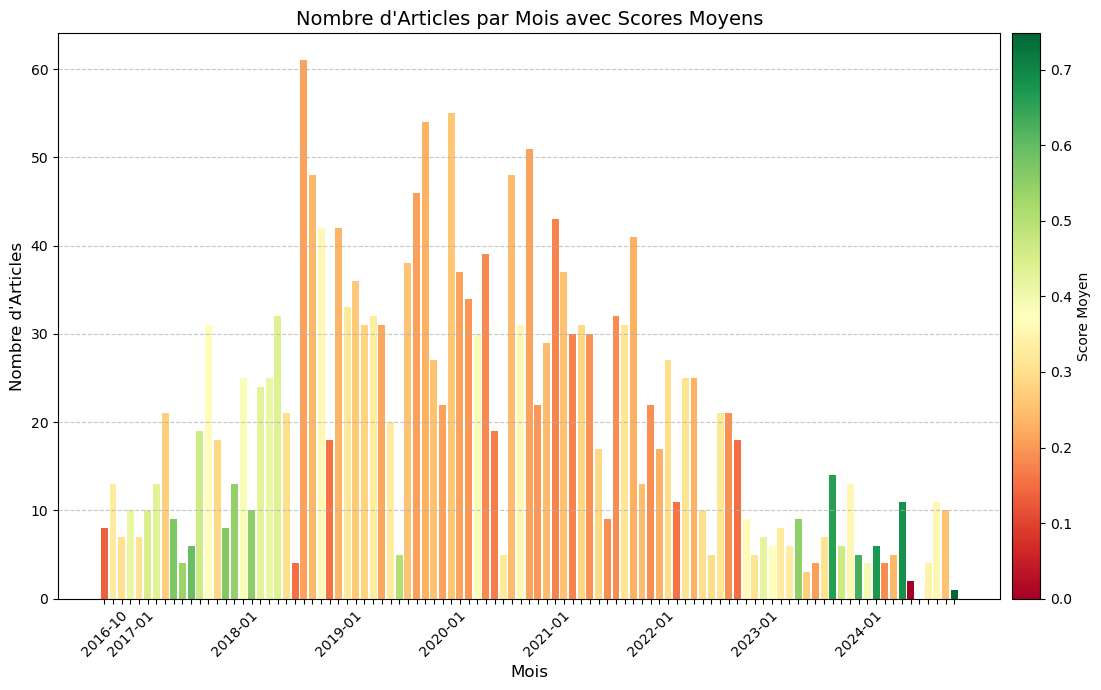

In [29]:
plot_months_with_color_based_on_score(enriched_articles_with_sentiment)


In [31]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime

headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36"}

def scrape_all_years(base_url_template, start_year, end_year):
    """
    Récupère les données pour toutes les années entre start_year et end_year, en continuant tant qu'il reste des pages.

    :param base_url_template: Modèle d'URL avec un espace réservé pour l'année et la page (par exemple, "https://www.lsa-conso.fr/marches/bio/annee_{year}/{page}/").
    :param start_year: Année de début.
    :param end_year: Année de fin.
    :return: Liste de dictionnaires contenant les données des articles.
    """
    all_articles = []  # Liste pour stocker les articles de toutes les années

    for year in range(start_year, end_year + 1):
        print(f"Scraping data for the year: {year}")
        page = 1
        while True:
            if page == 1:
                url = base_url_template.format(year=year, page="")  # URL de la première page
            else:
                url = base_url_template.format(year=year, page=f"{page}/")

            print(f"Scraping page: {url}")

            try:
                # Envoyer une requête HTTP pour récupérer la page
                response = requests.get(url, headers=headers, timeout=10)
                if response.status_code == 200:
                    soup = BeautifulSoup(response.text, 'html.parser')

                    # Trouver tous les articles via la classe "editoCardType10"
                    articles = soup.find_all("section", class_="editoCardType10")

                    if not articles:  # Si aucune donnée n'est trouvée, sortir de la boucle
                        print(f"Fin des pages pour l'année {year} à la page {page}.")
                        break

                    for article in articles:
                        # Extraire le lien de l'article
                        link_element = article.find("a", class_="editoCardType10__link is-displayBlock")
                        article_url = link_element['href'] if link_element and link_element.has_attr('href') else ""

                        # Extraire le titre
                        title_element = article.find("h2", class_="editoCardType10__title")
                        title_text = title_element.get_text(strip=True) if title_element else ""

                        # Extraire le résumé
                        summary_element = article.find("p", class_="editoCardType10__text is-noMobile")
                        summary_text = summary_element.get_text(strip=True) if summary_element else "Résumé non disponible"

                        # Extraire la date de publication
                        date_element = article.find("time", class_="editoCardType10__date is-noMobile")
                        publication_date = date_element["datetime"] if date_element and date_element.has_attr("datetime") else "Date inconnue"

                        # Ajouter l'article sous forme de dictionnaire
                        all_articles.append({
                            "title": title_text,
                            "summary": summary_text,
                            "url": f"https://www.lsa-conso.fr{article_url}",
                            "publication_date": publication_date
                        })

                elif response.status_code == 404:
                    print(f"Page {page} pour l'année {year} introuvable. Fin des pages.")
                    break
                else:
                    print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")
                    break

            except requests.RequestException as e:
                print(f"Erreur de requête pour {url}: {e}")
                break

            page += 1

    return all_articles

def add_sentiment_score_to_articles(articles):
    """
    Applique l'analyse de sentiment sur chaque phrase ajoutée à l'article
    et ajoute la moyenne des scores de sentiment à chaque article.
    
    :param articles: Liste de dictionnaires contenant les articles enrichis avec des clés comme 'title', 'summary', 'url'.
    :return: Liste de dictionnaires enrichis avec le score de sentiment moyen.
    """
    for article in articles:
        # Extraire le résumé contenant "bio" (clé 'summary')
        summary = article.get("summary", "")

        if summary and 'bio' in summary.lower():  # Appliquer l'analyse de sentiment uniquement si le résumé contient "bio"
            # Appliquer l'analyse de sentiment au résumé
            sentiment_score = analyze_sentiment_bio_with_model(summary)

            # Ajouter le score de sentiment au dictionnaire
            article["sentiment_score"] = sentiment_score
        else:
            # Si le résumé ne contient pas "bio", définir le score comme 0
            article["sentiment_score"] = 0

    return articles

def save_to_csv_final(data, filename):
    """
    Enregistre la liste de dictionnaires au format CSV.
    
    :param data: Liste de dictionnaires contenant les données des articles.
    :param filename: Nom du fichier CSV de sortie.
    """
    # Définir les en-têtes en fonction des clés des dictionnaires
    headers = [
        "Title", 
        "Summary", 
        "URL", 
        "Publication_Date", 
        "Sentiment_Score"
    ]
    
    # Écriture dans le fichier CSV
    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=headers)
        
        # Écrire les en-têtes
        writer.writeheader()
        
        # Écrire les données
        for article in data:
            # Extraire les données à partir du dictionnaire
            row = {
                "Title": article.get("title", ""),
                "Summary": article.get("summary", ""),
                "URL": article.get("url", ""),
                "Publication_Date": article.get("publication_date", ""),
                "Sentiment_Score": article.get("sentiment_score", 0)
            }
            writer.writerow(row)

    print(f"Les données ont été enregistrées dans le fichier '{filename}'.")

# Utilisation
base_url_template = "https://www.lsa-conso.fr/marches/bio/annee_{year}/{page}"
start_year = 2000
end_year = 2024
articles = scrape_all_years(base_url_template, start_year, end_year)

# Enrichir les articles avec les scores de sentiment
enriched_articles = add_sentiment_score_to_articles(articles)

# Enregistrement des articles enrichis avec score de sentiment dans un fichier CSV
save_to_csv_final(enriched_articles, "articles_bio_sentiment_all_years.csv")


Scraping data for the year: 2000
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2000/
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2000/2/
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2000/3/
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2000/4/
Page 4 pour l'année 2000 introuvable. Fin des pages.
Scraping data for the year: 2001
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2001/
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2001/2/
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2001/3/
Page 3 pour l'année 2001 introuvable. Fin des pages.
Scraping data for the year: 2002
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2002/
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2002/2/
Scraping page: https://www.lsa-conso.fr/marches/bio/annee_2002/3/
Page 3 pour l'année 2002 introuvable. Fin des pages.
Scraping data for the year: 2003
Scraping page: https://www.lsa-conso.fr/marches/bio/ann

In [34]:
enriched_articles_with_sentiment_total_years = add_sentiment_score_to_articles(enriched_articles)

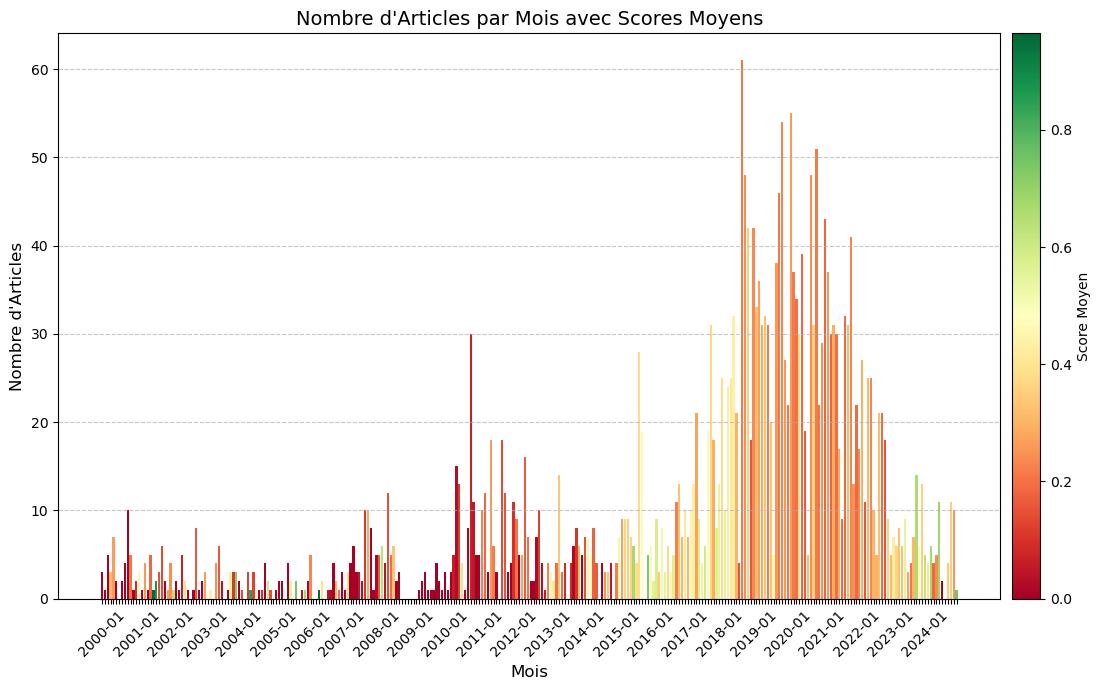

In [35]:
plot_months_with_color_based_on_score(enriched_articles_with_sentiment_total_years)